# Notebook 2 : Modélisation et évaluation avancée

**Auteur :** Mehdi MUNIM

**Date :** 2023-10

**Description :**

Ce notebook explore le développement, l'entraînement et l'évaluation de différents modèles de Machine Learning pour la classification de sentiment sur des tweets. Nous allons comparer les performances de
- un modèle de base (baseline)
- 3 modèles de  Deep Learning personnalisés
  * MLP
  * CNN
  * LSTM

**Objectif :**

L'objectif est de construire et d'évaluer des modèles capables de prédire avec précision le sentiment (positif ou négatif) exprimé dans des tweets.

In [ ]:
#@title 1. Imports et configuration de Google Drive

# Importation des librairies nécessaires pour la modélisation
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Montage de Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. Chargement et préparation des données

In [ ]:
#@title 2.1. Choix d'une méthode

# Demander à l'utilisateur de choisir une méthode de prétraitement
methode = input("Entrez la méthode de prétraitement (tfidf, word2vec, ou doc2vec) : ")

# Vérifier si la méthode est valide
while methode not in ["tfidf", "word2vec", "doc2vec"]:
    print("Méthode invalide. Veuillez choisir parmi tfidf, word2vec, ou doc2vec.")
    methode = input("Entrez la méthode de prétraitement (tfidf, word2vec, ou doc2vec) : ")

print(f"Méthode sélectionnée : {methode}")

Entrez la méthode de prétraitement (tfidf, word2vec, ou doc2vec) : word2vec
Méthode sélectionnée : word2vec


In [ ]:
#@title 2.2. Chargement des données


import pickle

# Chemin d'accès au dossier sur le Drive
drive_path = "/content/drive/My Drive/OC/OC7/data/"

# Fonction pour charger les données
def charger_donnees(methode):
    with open(drive_path + methode + '/X_train.pickle', 'rb') as f:
        X_train = pickle.load(f)
    with open(drive_path + methode + '/X_test.pickle', 'rb') as f:
        X_test = pickle.load(f)
    with open(drive_path + 'y_train.pickle', 'rb') as f:
        y_train = pickle.load(f)
    with open(drive_path + 'y_test.pickle', 'rb') as f:
        y_test = pickle.load(f)
    return X_train, X_test, y_train, y_test


# Charger les données avec la méthode sélectionnée
X_train, X_test, y_train, y_test = charger_donnees(methode)

# Afficher les informations sur les données chargées
print(f"Données chargées avec la méthode {methode} :")
print(f"  X_train : {X_train.shape}")
print(f"  X_test : {X_test.shape}")
print(f"  y_train : {y_train.shape}")
print(f"  y_test : {y_test.shape}")

Données chargées avec la méthode word2vec :
  X_train : (1280000, 100)
  X_test : (320000, 100)
  y_train : (1280000,)
  y_test : (320000,)


---

Les données TF-IDF sont bien plus massives que le reste et sont mise dans le format d'une "sparse matrix" (matrice creuse)

---

## 2.1 Réduction de la dimensionnalité avec SelectKBest

Pour gérer la grande dimensionnalité des données TF-IDF et éviter les problèmes de mémoire, nous allons utiliser la méthode `SelectKBest` avec un test du chi2.

Cette technique permet de sélectionner les `k` features (mots) les plus importantes pour la classification, en fonction de leur dépendance statistique avec le sentiment exprimé dans les tweets.

Nous allons sélectionner les n meilleures features, ce qui devrait permettre de réduire significativement la dimensionnalité des données tout en conservant les informations les plus pertinentes pour la classification.


In [ ]:
#@title 2.1 Réduction de la dimensionnalité avec SelectKBest

from sklearn.feature_selection import SelectKBest, f_classif

# Sélectionner les n meilleures features avec le test ANOVA F-value
selector = SelectKBest(f_classif, k=30)  # Remplacer chi2 par f_classif

# Appliquer SelectKBest sur les données d'entraînement
X_train_kbest = selector.fit_transform(X_train, y_train)

# Appliquer la même transformation sur les données de test
X_test_kbest = selector.transform(X_test)

# Afficher les dimensions des données réduites
print("Dimensions de X_train_kbest :", X_train_kbest.shape)
print("Dimensions de X_test_kbest :", X_test_kbest.shape)

Dimensions de X_train_kbest : (1280000, 30)
Dimensions de X_test_kbest : (320000, 30)


## 3. Modèle de base (baseline)

In [ ]:
#@title 3. Entraînement du modèle de régression logistique

# Création d'un modèle de régression logistique avec le solveur liblinear
model_baseline = LogisticRegression(solver='liblinear',
                                    max_iter=1000,
                                    random_state=42)

# Entraînement du modèle sur les données d'entraînement réduites avec ACP
model_baseline.fit(X_train_kbest, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

### 3.1 Évaluation du modèle de base

Nous allons évaluer le modèle de base en utilisant les métriques vues précédemment (accuracy, precision, recall, F1-score) et la matrice de confusion.

In [ ]:
#@title 3.1 Fonction pour évaluer les modèles

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Fonction pour afficher les métriques d'évaluation et les courbes
def evaluer_modele(model, X_test, y_test):
    # Obtenir les prédictions du modèle
    if isinstance(model, Sequential):  # Vérifier si le modèle est un modèle Keras
        y_pred = model.predict(X_test).flatten()
        y_pred = (y_pred > 0.5).astype(int)  # Convertir les probabilités en classes prédites si nécessaire
    else:
        y_pred = model.predict(X_test)

    # Calculer les métriques d'évaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Afficher les métriques
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Calculer la courbe ROC et l'AUC (si possible)
    try:
        if isinstance(model, Sequential):
            y_pred_proba = model.predict(X_test).flatten()  # Obtenir les probabilités pour les modèles Keras
        else:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Afficher la matrice de confusion et la courbe ROC côte à côte
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Matrice de confusion
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title('Matrice de confusion')
        axes[0].set_ylabel('Vraie classe')
        axes[0].set_xlabel('Classe prédite')

        # Courbe ROC
        axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('Taux de faux positifs')
        axes[1].set_ylabel('Taux de vrais positifs')
        axes[1].set_title('Courbe ROC')
        axes[1].legend(loc="lower right")

        plt.tight_layout()
        plt.show()

    except AttributeError:
        print("Le modèle ne supporte pas la méthode predict_proba. Impossible d'afficher la courbe ROC.")


Évaluation du modèle de base :
Accuracy: 0.7222
Precision: 0.7214
Recall: 0.7270
F1-score: 0.7242


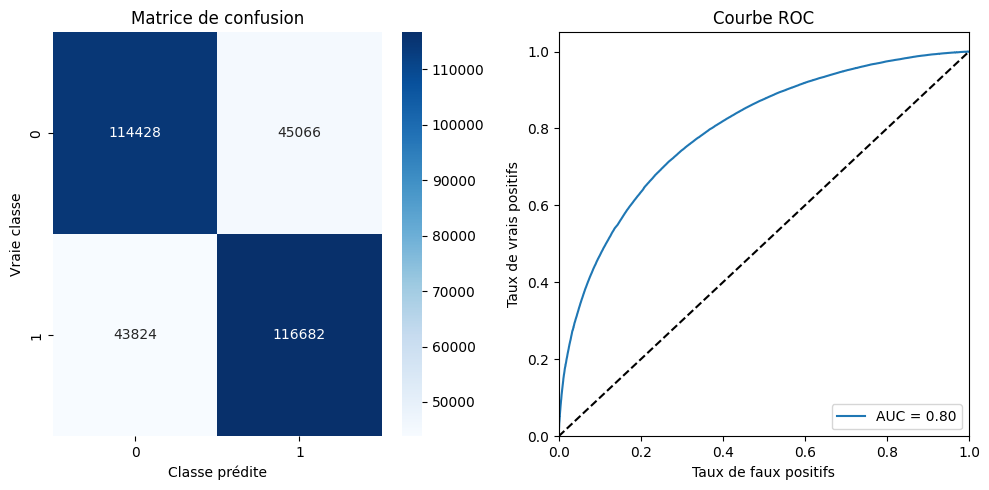

In [ ]:
#@title 3.2 Évaluation du modèle de base


# Évaluation du modèle de base (régression logistique)
print("Évaluation du modèle de base :")
evaluer_modele(model_baseline, X_test_kbest, y_test)

## 4. Modèles Deep Learning personnalisé

Nous allons maintenant construire un modèle Deep Learning personnalisé pour la classification de sentiment.

### 4.1 - MLP (couches dense uniquement)

In [ ]:
#@title Construction du modèle MLP

# Définir la longueur maximale des séquences (nombre de features)
max_length = X_train_kbest.shape[1]

# Définition du modèle Deep Learning plus complexe
model_dl = Sequential()
model_dl.add(Dense(units=64, activation='relu', input_shape=(max_length,)))  # Augmentation du nombre de neurones
model_dl.add(Dropout(0.4))  # Diminution du taux de dropout
model_dl.add(Dense(units=32, activation='relu'))  # Ajout d'une couche Dense
model_dl.add(Dropout(0.3))  # Ajout d'une couche de dropout
model_dl.add(Dense(units=1, activation='sigmoid'))  # Couche de sortie

# Compilation du modèle
model_dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Afficher l'architecture du modèle
model_dl.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

---

t < 30min

---

In [ ]:
#@title Entraînement du modèle MLP

# Entraînement du modèle sur les données d'entraînement avec une taille de batch plus petite
history = model_dl.fit(X_train_kbest,
                       y_train,
                       epochs=10,
                       batch_size=16,
                       validation_split=0.2)

Epoch 1/10
64000/64000 ━━━━━━━━━━━━━━━━━━━━ 155s 2ms/step - accuracy: 0.7186 - loss: 0.5512 - val_accuracy: 0.7355 - val_loss: 0.5276
Epoch 2/10
64000/64000 ━━━━━━━━━━━━━━━━━━━━ 160s 3ms/step - accuracy: 0.7297 - loss: 0.5370 - val_accuracy: 0.7354 - val_loss: 0.5272
Epoch 3/10
64000/64000 ━━━━━━━━━━━━━━━━━━━━ 241s 3ms/step - accuracy: 0.7310 - loss: 0.5344 - val_accuracy: 0.7372 - val_loss: 0.5234
Epoch 4/10
64000/64000 ━━━━━━━━━━━━━━━━━━━━ 196s 3ms/step - accuracy: 0.7331 - loss: 0.5336 - val_accuracy: 0.7365 - val_loss: 0.5249
Epoch 5/10
64000/64000 ━━━━━━━━━━━━━━━━━━━━ 191s 3ms/step - accuracy: 0.7330 - loss: 0.5333 - val_accuracy: 0.7376 - val_loss: 0.5223
Epoch 6/10
64000/64000 ━━━━━━━━━━━━━━━━━━━━ 189s 3ms/step - accuracy: 0.7331 - loss: 0.5327 - val_accuracy: 0.7379 - val_loss: 0.5267
Epoch 7/10
64000/64000 ━━━━━━━━━━━━━━━━━━━━ 174s 3ms/step - accuracy: 0.7330 - loss: 0.5325 - val_accuracy: 0.7375 - val_loss: 0.5227
Epoch 8/10
64000/64000 ━━━━━━━━━━━━━━━━━━━━ 205s 3ms/step - ac


Évaluation du modèle Deep Learning :
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
Accuracy: 0.7389
Precision: 0.7389
Recall: 0.7413
F1-score: 0.7401
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step


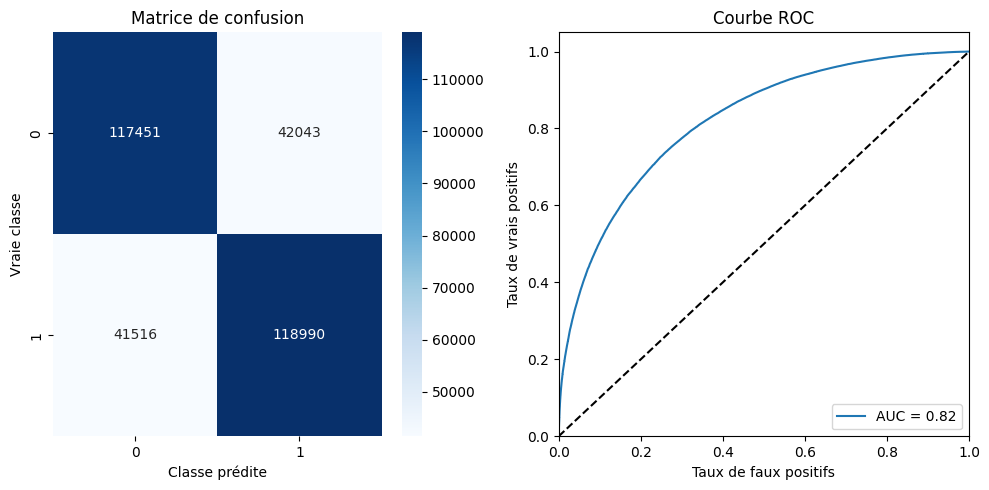

In [ ]:
#@title Évaluation du modèle MLP

# Évaluation du modèle Deep Learning
print("\nÉvaluation du modèle Deep Learning :")
evaluer_modele(model_dl, X_test_kbest, y_test)

In [ ]:
#@title Sauvegarde du modèle MLP

import os

# Créer le dossier "models" s'il n'existe pas
os.makedirs(drive_path + "models", exist_ok=True)

# Sauvegarder le modèle Deep Learning
model_dl.save(drive_path + "models/model_dl.keras")

### 4.2 - CNN (réseau convolutif 1D)

In [ ]:
#@title Construction du modèle CNN

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Définir la longueur maximale des séquences (nombre de features)
max_length = X_train_kbest.shape[1]


# Définition du modèle CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(max_length, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Afficher l'architecture du modèle
model_cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,721 (26.25 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title Entraînement du modèle CNN (avec conversion en tableaux denses)

# Convertir les matrices creuses en tableaux NumPy denses
X_train_dense = X_train_kbest
X_test_dense = X_test_kbest

# Reshape les données pour qu'elles soient compatibles avec Conv1D
X_train_cnn = X_train_dense.reshape((-1, X_train_kbest.shape[1], 1))
X_test_cnn = X_test_dense.reshape((-1, X_test_kbest.shape[1], 1))

# Entraînement du modèle sur les données d'entraînement
history = model_cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 166s 5ms/step - accuracy: 0.7196 - loss: 0.5444 - val_accuracy: 0.7276 - val_loss: 0.5358
Epoch 2/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 206s 5ms/step - accuracy: 0.7299 - loss: 0.5316 - val_accuracy: 0.7319 - val_loss: 0.5296
Epoch 3/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 155s 5ms/step - accuracy: 0.7301 - loss: 0.5303 - val_accuracy: 0.7312 - val_loss: 0.5295
Epoch 4/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 159s 5ms/step - accuracy: 0.7319 - loss: 0.5289 - val_accuracy: 0.7322 - val_loss: 0.5281
Epoch 5/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 197s 5ms/step - accuracy: 0.7326 - loss: 0.5271 - val_accuracy: 0.7322 - val_loss: 0.5279
Epoch 6/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.7325 - loss: 0.5271 - val_accuracy: 0.7290 - val_loss: 0.5315
Epoch 7/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.7329 - loss: 0.5266 - val_accuracy: 0.7308 - val_loss: 0.5294
Epoch 8/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 160s 5ms/step - ac

In [ ]:
#@title Sauvegarde du modèle CNN

import os

# Chemin d'accès au dossier sur le Drive
drive_path = "/content/drive/My Drive/OC/OC7/"

# Créer le dossier "models" s'il n'existe pas
os.makedirs(drive_path + "models", exist_ok=True)

# Sauvegarder le modèle CNN
model_cnn.save(drive_path + "models/model_cnn.keras")


Évaluation du modèle CNN :
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
Accuracy: 0.7317
Precision: 0.7121
Recall: 0.7805
F1-score: 0.7448
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


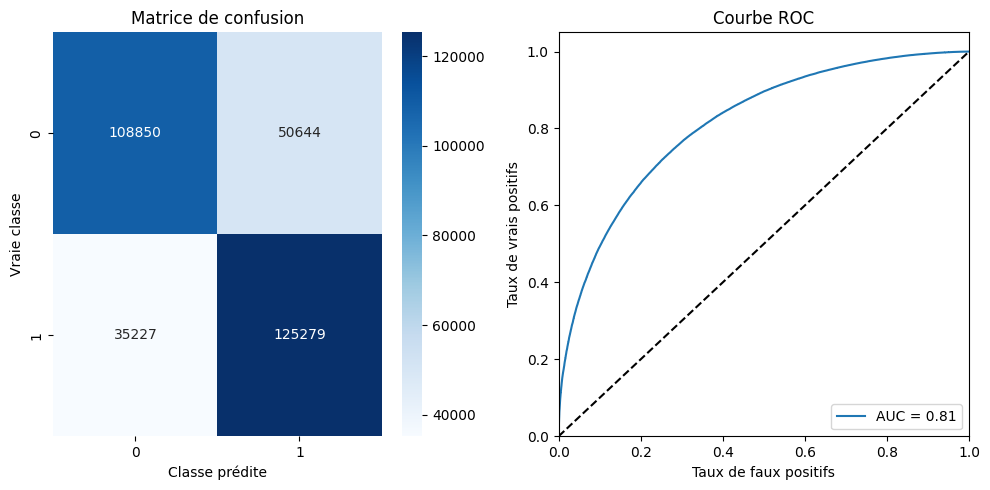

In [ ]:
#@title Évaluation du modèle CNN

# Évaluation du modèle CNN
print("\nÉvaluation du modèle CNN :")
evaluer_modele(model_cnn, X_test_cnn, y_test)

### 4.3 - LSTM (réseau récurrent)

In [ ]:
#@title Construction du modèle LSTM avec données pré-vectorisées

from tensorflow.keras.layers import LSTM, Input, Lambda
import tensorflow as tf

# Définir la longueur maximale des séquences (nombre de features)
max_length = X_train_kbest.shape[1]

# Définition du modèle LSTM
model_lstm = Sequential()
model_lstm.add(Input(shape=(max_length,)))  # Couche d'entrée avec la dimension des embeddings

# Reshape les données pour ajouter une dimension temporelle
model_lstm.add(Lambda(lambda x: tf.expand_dims(x, axis=1)))  # Ajout d'une dimension temporelle

model_lstm.add(LSTM(units=64))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Afficher l'architecture du modèle
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 1, 30)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          24,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,385 (95.25 KB)

 Trainable params: 24,385 (95.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title Entraînement du modèle LSTM

# Entraînement du modèle sur les données d'entraînement
history = model_lstm.fit(X_train_kbest, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 114s 3ms/step - accuracy: 0.7264 - loss: 0.5366 - val_accuracy: 0.7388 - val_loss: 0.5185
Epoch 2/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 150s 4ms/step - accuracy: 0.7379 - loss: 0.5194 - val_accuracy: 0.7420 - val_loss: 0.5133
Epoch 3/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 113s 4ms/step - accuracy: 0.7417 - loss: 0.5150 - val_accuracy: 0.7430 - val_loss: 0.5118
Epoch 4/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.7429 - loss: 0.5123 - val_accuracy: 0.7449 - val_loss: 0.5099
Epoch 5/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - accuracy: 0.7436 - loss: 0.5119 - val_accuracy: 0.7456 - val_loss: 0.5088
Epoch 6/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 150s 4ms/step - accuracy: 0.7445 - loss: 0.5098 - val_accuracy: 0.7463 - val_loss: 0.5081
Epoch 7/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 107s 3ms/step - accuracy: 0.7445 - loss: 0.5102 - val_accuracy: 0.7468 - val_loss: 0.5071
Epoch 8/10
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 109s 3ms/step - ac

---

Fastext

---


Évaluation du modèle LSTM :
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
Accuracy: 0.7472
Precision: 0.7479
Recall: 0.7483
F1-score: 0.7481
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


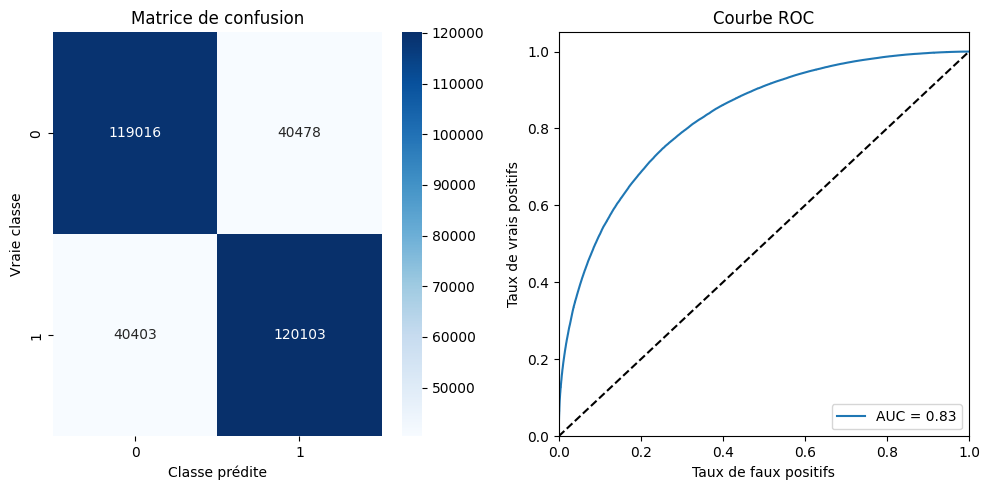

In [ ]:
#@title Évaluation du modèle LSTM

# Évaluation du modèle LSTM
print("\nÉvaluation du modèle LSTM :")
evaluer_modele(model_lstm, X_test_kbest, y_test)

In [ ]:
#@title Sauvegarde du modèle LSTM

import os

# Chemin d'accès au dossier sur le Drive
drive_path = "/content/drive/My Drive/OC/OC7/"

# Créer le dossier "models" s'il n'existe pas
os.makedirs(drive_path + "models", exist_ok=True)

# Sauvegarder le modèle LSTM
model_lstm.save(drive_path + "models/model_lstm.keras")